# Short Assignment 3

**Due:** Friday, February 11 @ 11:59pm

This is an individual assignment.

# Question 1

Suppose that a taxi company wants to estimate the average number of trips per hour for the upcoming Valentine's Day weekend. The company is working under the assumption that the number of passengers can be modeled with a Poisson random variable (RV) with parameter $\lambda$ ($\lambda>0$).

* The poisson RV with parameter $\lambda$ has the following probability mass function (PMF): $p(x) = \frac{\lambda^x e^{-\lambda}}{x!}$.

The company's engineers decide to use a Gamma RV with parameters $\alpha=5$ and $\beta=0.5$ as the prior probability for the unknown parameter $\lambda$.

* The Gamma RV with parameters $\alpha$ and $\beta$ ($\alpha,\beta>0$) has the following probability density function: $f(\lambda)=\frac{\beta^{\alpha}}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta\lambda}$.

Answer the following questions:

1. Compute the MLE and the MAP estimate for $\lambda$. Show all your work. (Review your work from HW1-P2 Question 2.)

2. Does Poisson-Gamma form a prior conjugate relationship? Provide the pseudo-code for online updated of the prior parameters.

3. Suppose the dataset ```hourly_trips.npy``` is the dataset coming in hourly (one sample at a time) starting Feb 12 at 4pm. Use this data to perform online update of the prior parameters. Start with an initial guess of $\alpha=3$ and $\beta=1$. Include a plot showing the estimated value for $\lambda$ (using MLE and MAP) as more data samples are collected. (The true value is $\lambda=10$.)

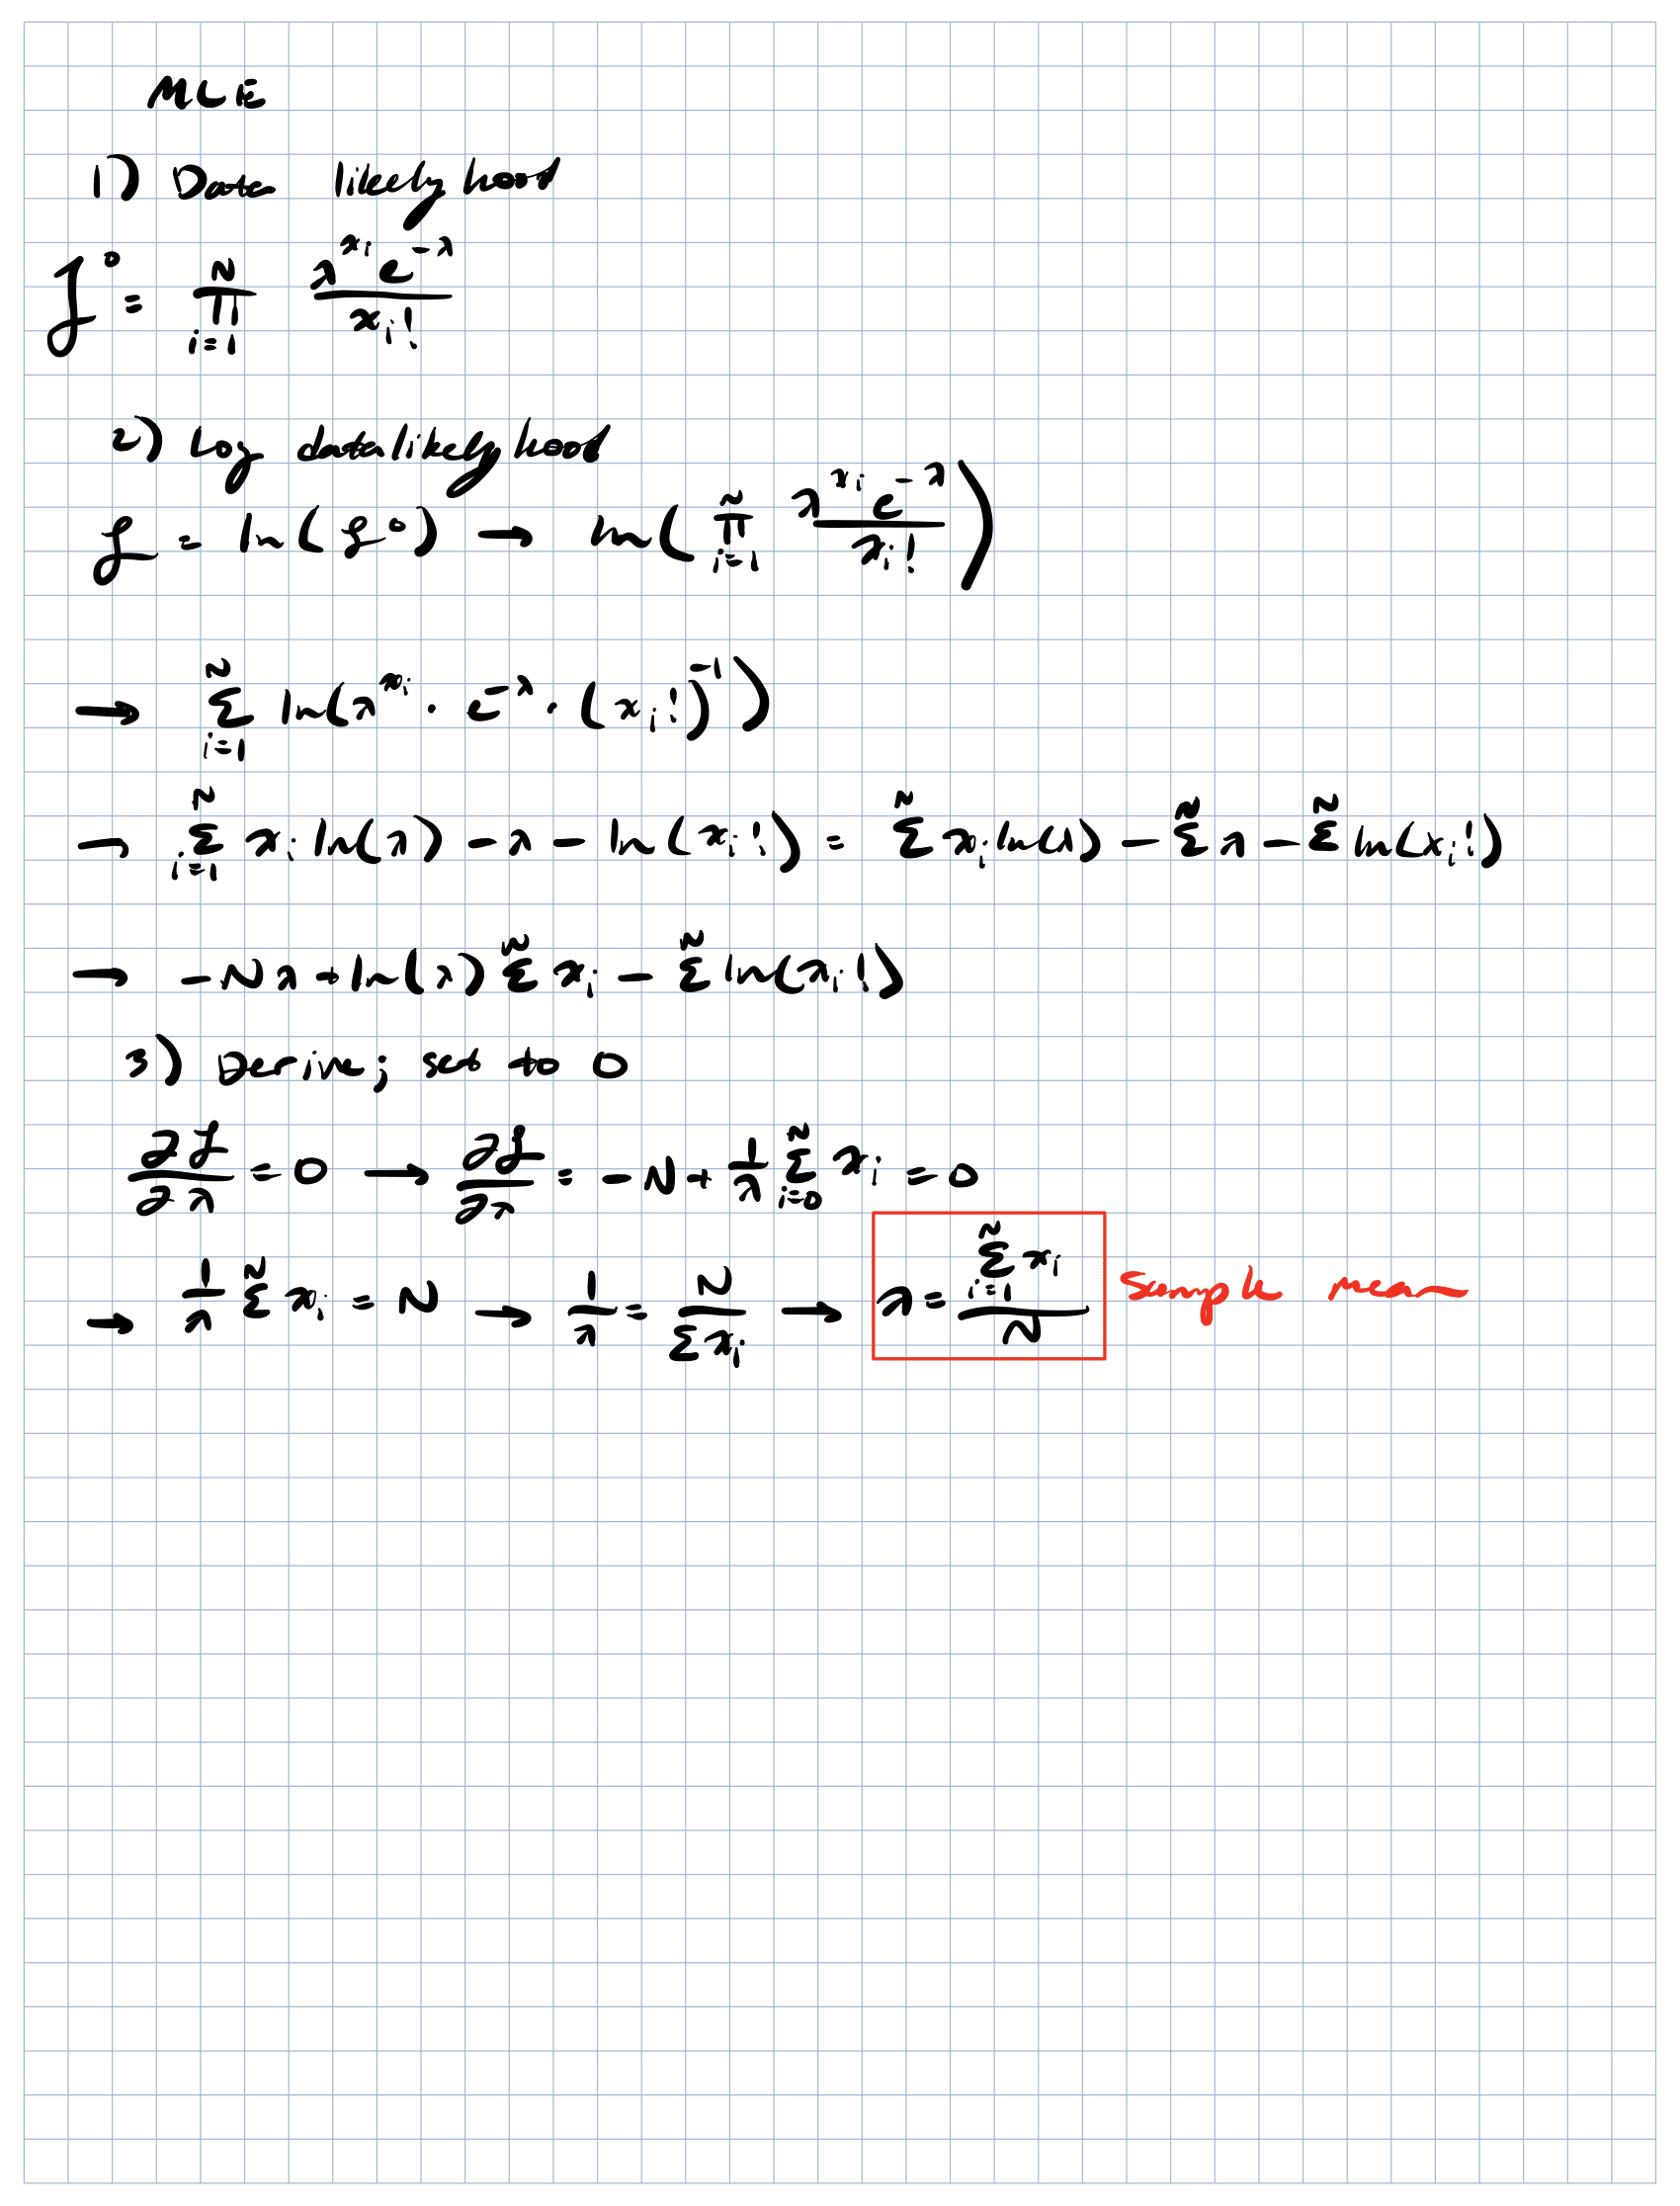

In [1]:
from IPython.display import Image
Image('Figures/Short_assignment_3-1.png', width=700)

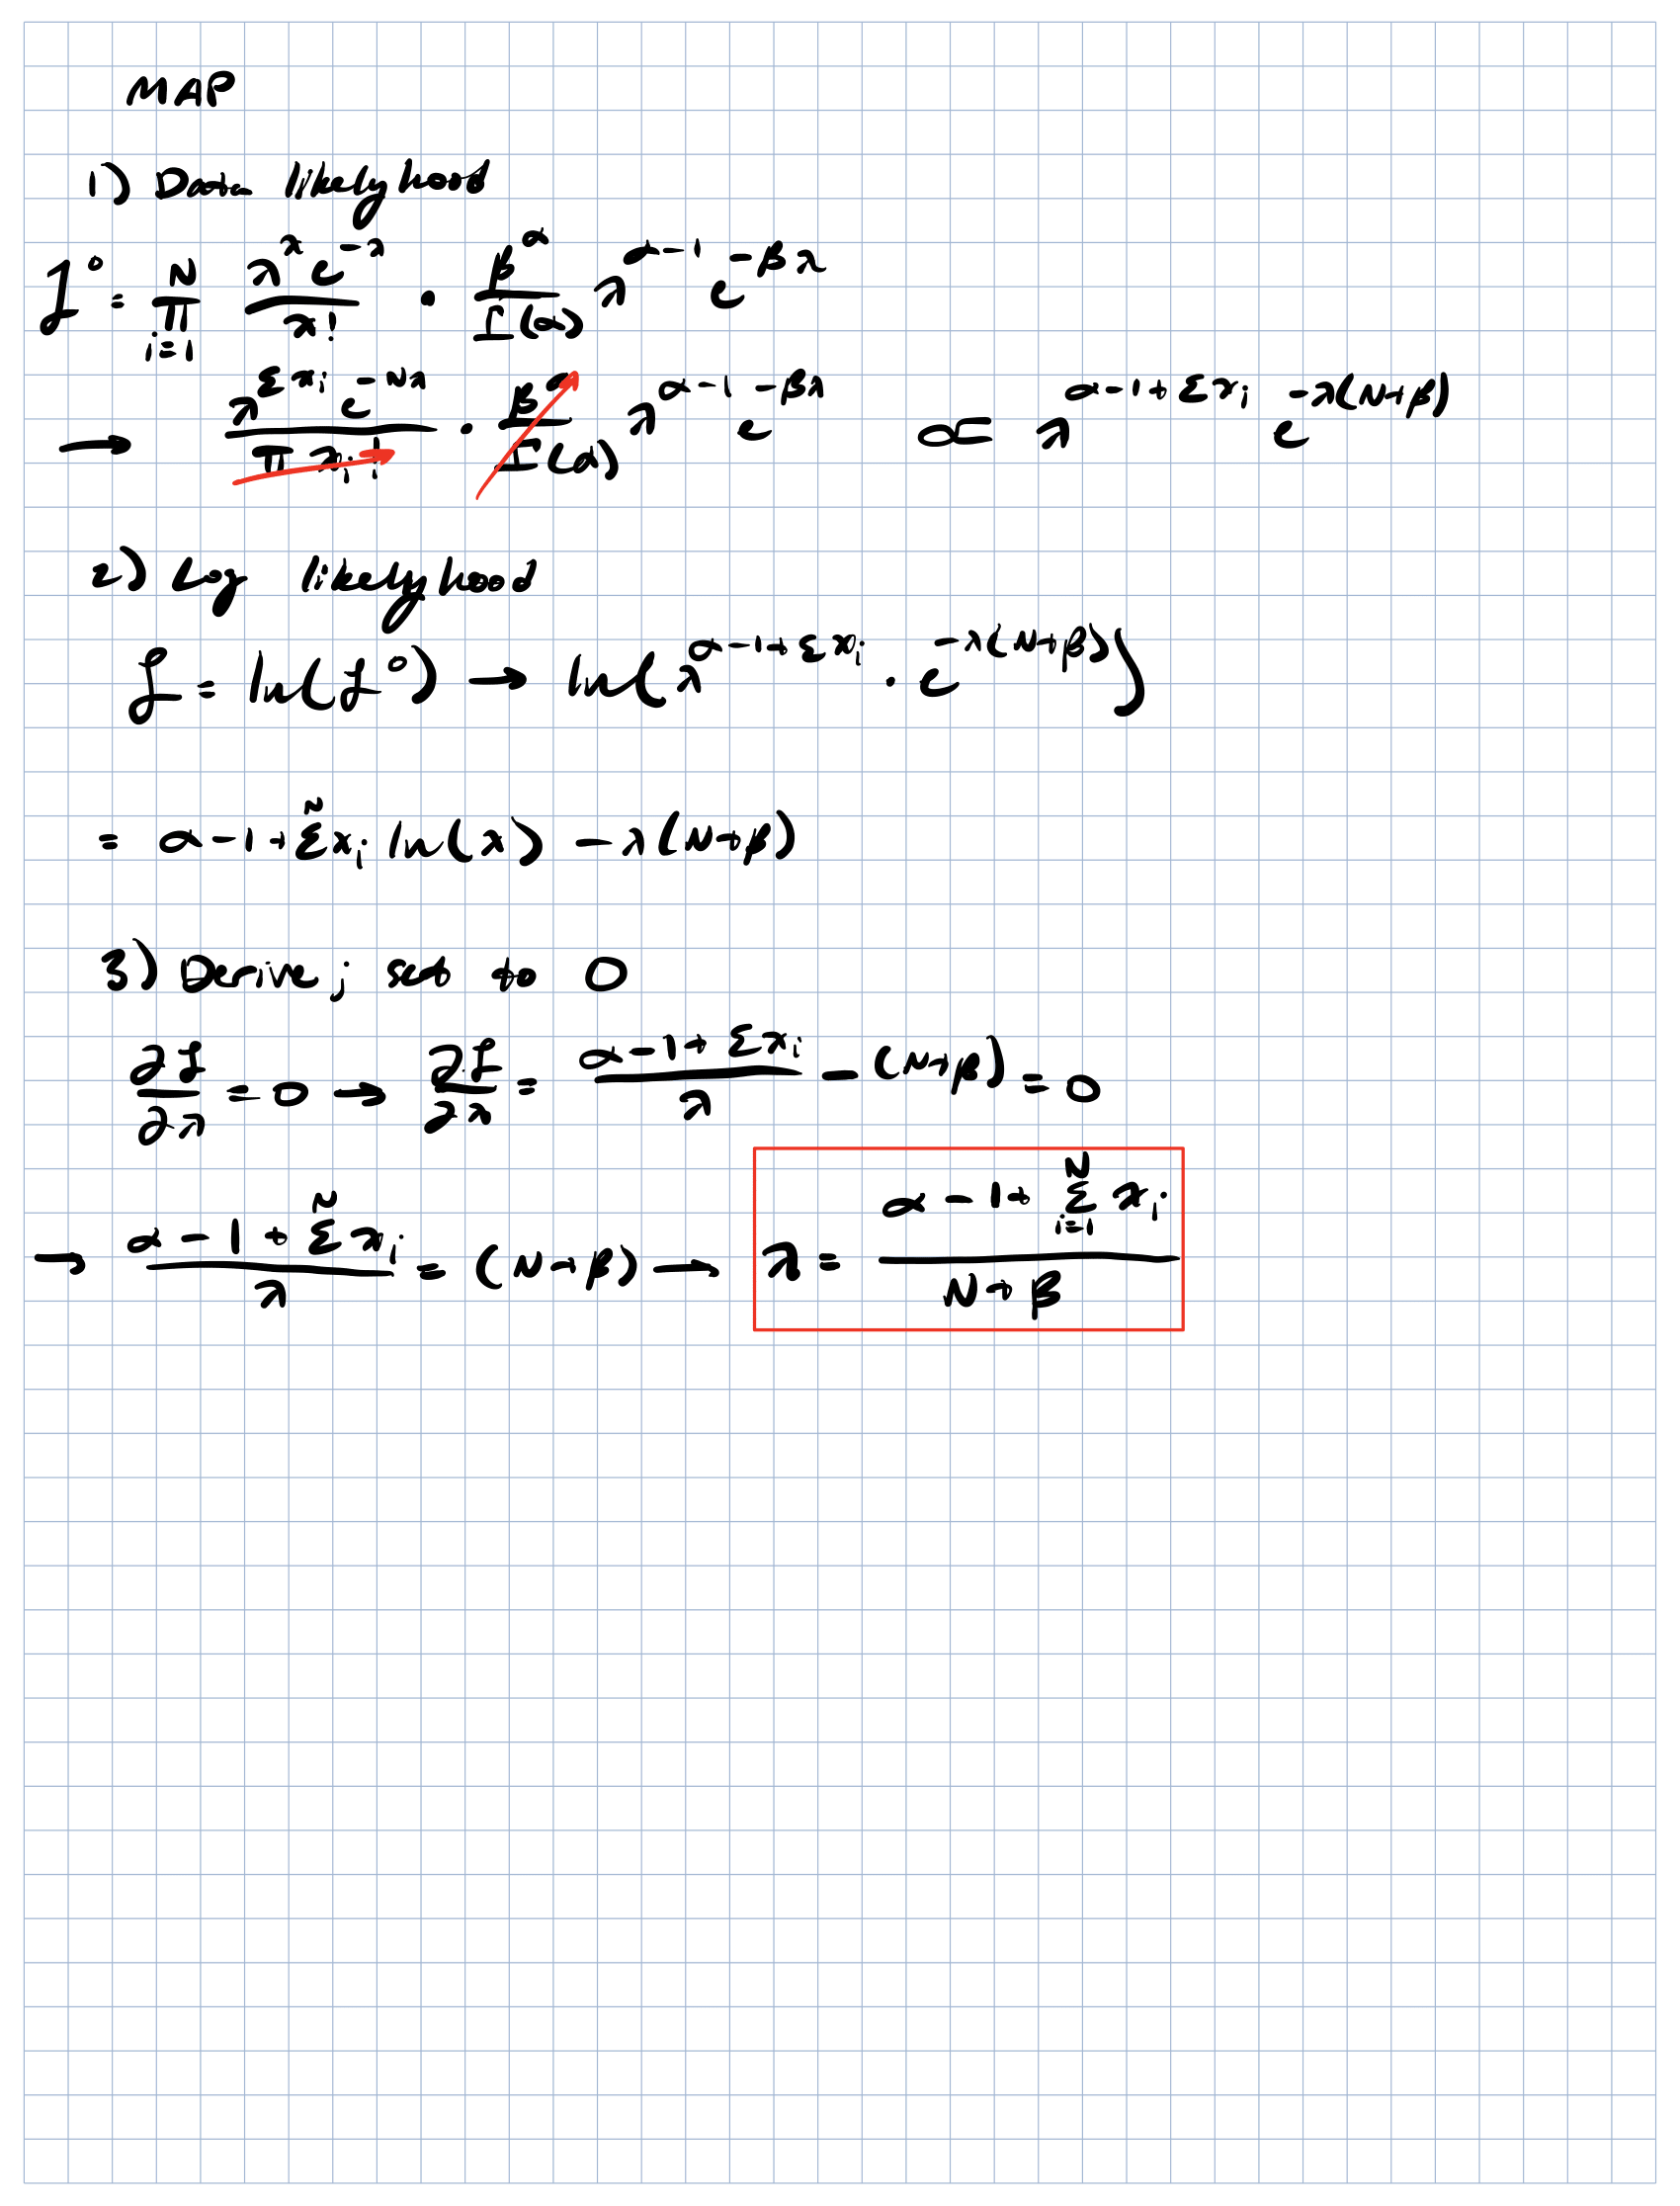

In [2]:
Image('Figures/Short_assignment_3-2.png', width=700)

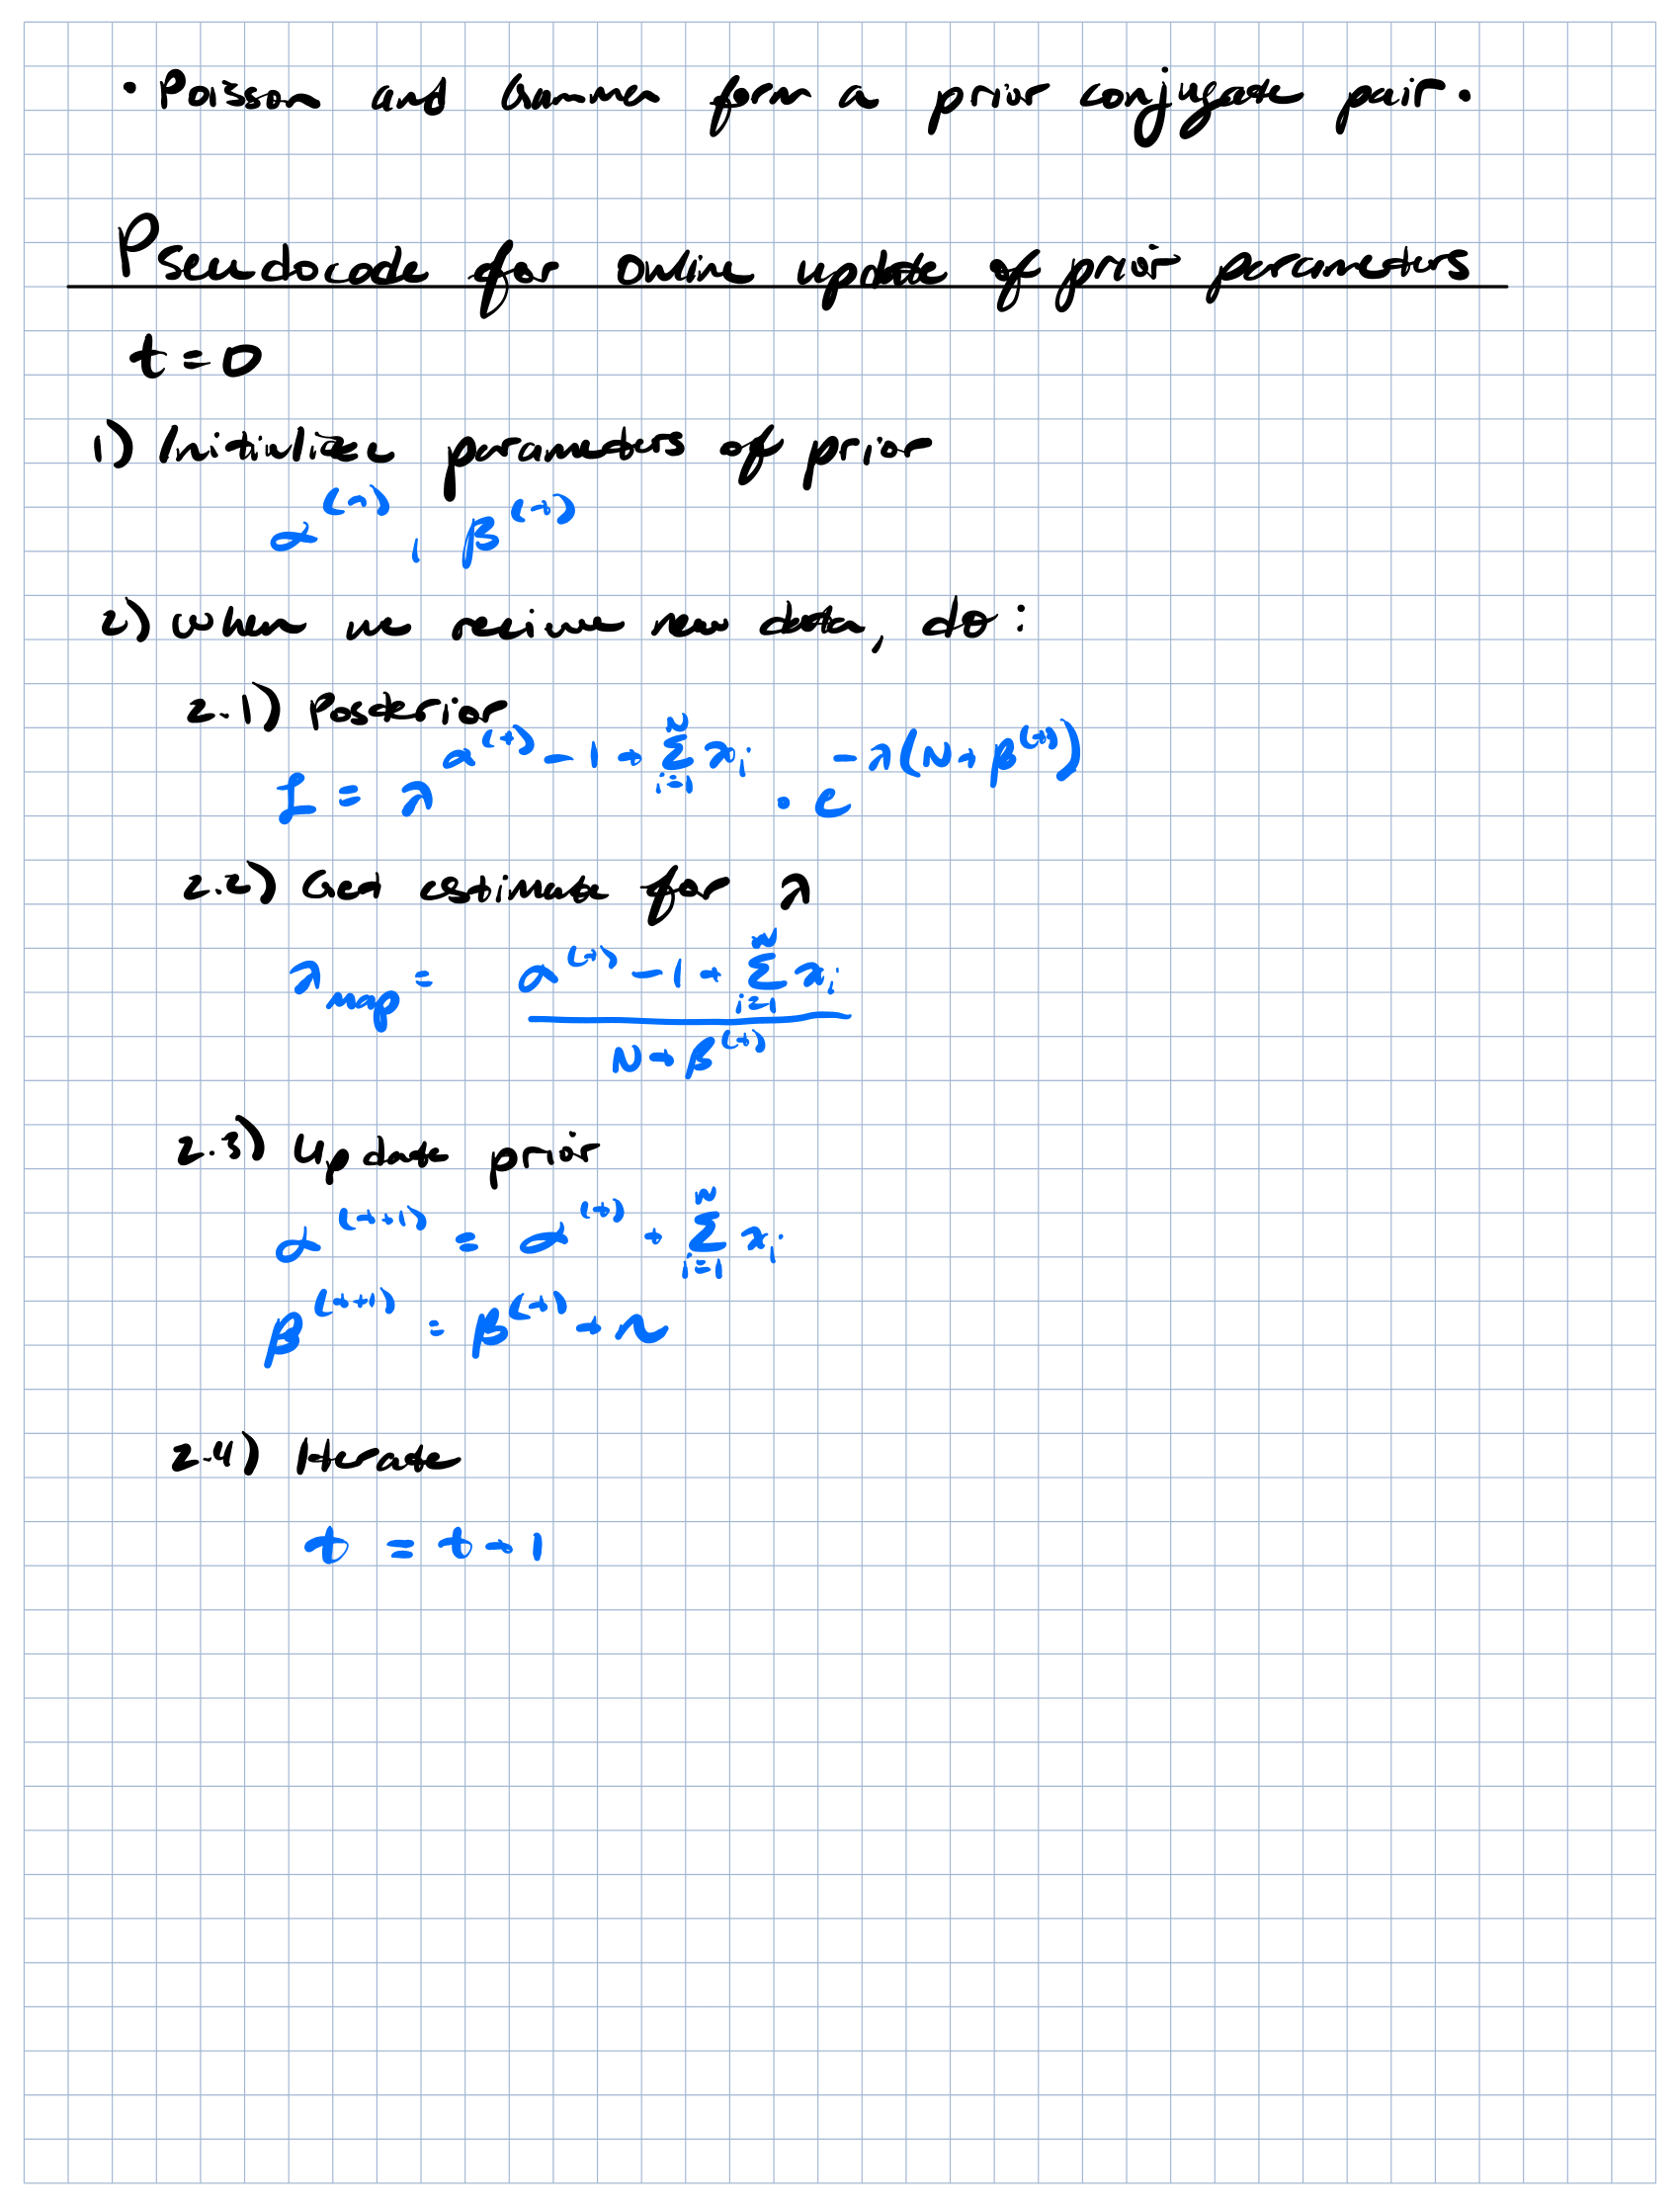

In [3]:
Image('Figures/Short_assignment_3-3.png', width=700)

MLE ESTIMATE: 9.794278538442299
MAP ESTIMATE: 9.935638942946206


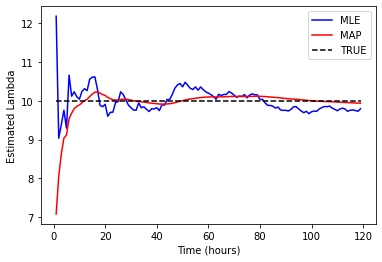

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

a = 3
b = 1
X = np.load('hourly_trips.npy')
MLE, MAP, TRUE = [], [], np.full(shape=(119), fill_value=10)
domain = np.linspace(1, X.size-1, X.size-1)

for t in range(1,X.size):
    x = X[:t]
    MAP.append((a-1+np.sum(x))*(1/(x.size+b)))
    MLE.append(np.mean(x))
    a = a + np.sum(x)
    b = b + x.size
    
print(f'MLE ESTIMATE: {MLE[-1]}')
print(f'MAP ESTIMATE: {MAP[-1]}')

plt.plot(domain, MLE, c='b', label='MLE')
plt.plot(domain, MAP, c='r', label='MAP')
plt.plot(domain, TRUE, 'k--', label='TRUE')
plt.xlabel('Time (hours)')
plt.ylabel('Estimated Lambda')
plt.legend(fontsize=10);

___

# Question 2

In this problem, you will implement the Naive Bayes Classifier on the **Breast Cancer Wisconsin Dataset**.

### Breast Cancer Wisconsin Dataset

This dataset is available as part of the datasets' database on ```scikit-learn```.

Data was collected from 569 digitized image of a fine needle aspirate (FNA) of a breast mass. For each FNA image, 30 features were automatically extracted, including: average cell radius, average cell texture, average cell perimeter, average cell area, average cell smoothness, and 25 others.

Let's load the dataset for a full description:

In [5]:
from sklearn.datasets import load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

In [6]:
data = load_breast_cancer(return_X_y=False)

In [7]:
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

A subset of these 569 samples are labeled as malignant and others as benign.

In [8]:
# 0 - Malignant, 1 - benign
target = data.target

np.unique(target)

array([0, 1])

In [9]:
print('There are ',np.sum(target==0),' samples labeled as malignant')
print('There are ',np.sum(target==1),' samples labeled as benign')

There are  212  samples labeled as malignant
There are  357  samples labeled as benign


For this problem, let's consider the first two features only. Those are the radius and texture:

In [10]:
X = data.data[:,0:2]

print(X.shape)

(569, 2)


The matrix X contains all samples for these 2 features. We can further separate them into malignant samples and benign samples:

In [11]:
X_mal = X[target==0,:]
X_ben = X[target==1,:]

print(X_mal.shape, X_ben.shape)

(212, 2) (357, 2)


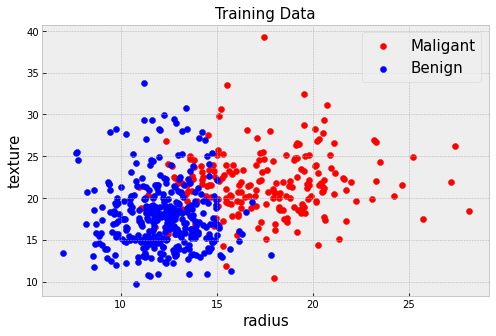

In [12]:
plt.figure(figsize=(8,5))
plt.scatter(X_mal[:,0], X_mal[:,1], c='r',label='Maligant')
plt.scatter(X_ben[:,0], X_ben[:,1], c='b',label='Benign')
plt.legend(fontsize=15); plt.title('Training Data', size=15)
plt.xlabel('radius',size=15)
plt.ylabel('texture', size=15);

# Problem

Answer the following questions:

1. Compute the MLE estimate for the mean and covariance matrix for both classes.

2. Compute the prior probabilities for both classes.

3. Compute and display (using ```imshow```) the data likelihood for both classes.

4. Compute the posterior distribution for both classes, and plot the decision boundary.

5. Suppose that the hospital collected another FNA and measured an average radius of 18 and an average texture of 22. Using your classifier, how would you classify that new point? How confident are you in that decision?

6. Consider another new sample with radius 30 and texture 30. What classification would you report back to the doctor? How confident are you in that decision?

As we found in class, the MLE estimate for each class is just the sample mean for that class. The MLE estimate for the covariance is an isotropic matrix of the samle variance.

In [13]:
import scipy.stats as stats

In [14]:
MLEmal = np.mean(X_mal, axis=0) #MEAN
COVmal = np.cov(X_mal.T) #COVARIANCE MATRIX

MLEben = np.mean(X_ben, axis=0)
COVben = np.cov(X_ben.T)

print(MLEmal)
print(MLEben)

N = X_mal.shape[0] + X_ben.shape[0] #TOTAL SAMPLES

pMal = X_mal.shape[0]/N #PRIOR
pBen = X_ben.shape[0]/N

[17.46283019 21.60490566]
[12.14652381 17.9147619 ]


In [15]:
#SETUP
grid = 40
x = np.linspace(0, grid, 100)
y = np.linspace(0, grid, 100)
xm, ym = np.meshgrid(x,y)
X = np.flip(np.dstack([xm,ym]), axis=0)

In [16]:
Gmal = stats.multivariate_normal.pdf(X, mean=MLEmal, cov=COVmal) #P(x|MAL)
Gben = stats.multivariate_normal.pdf(X, mean=MLEben, cov=COVben) #P(x|BEN)

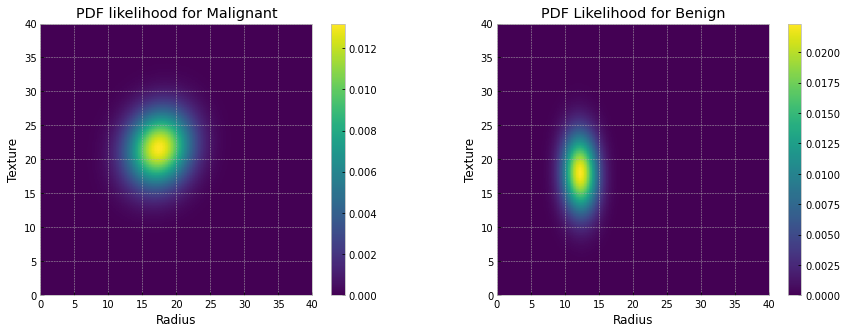

In [17]:
#SETUP GRAPHS
fig = plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.imshow(Gmal, extent=[0,grid,0,grid])
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.title('PDF likelihood for Malignant')

fig.add_subplot(1,2,2)
plt.imshow(Gben, extent=[0,grid,0,grid])
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.title('PDF Likelihood for Benign');

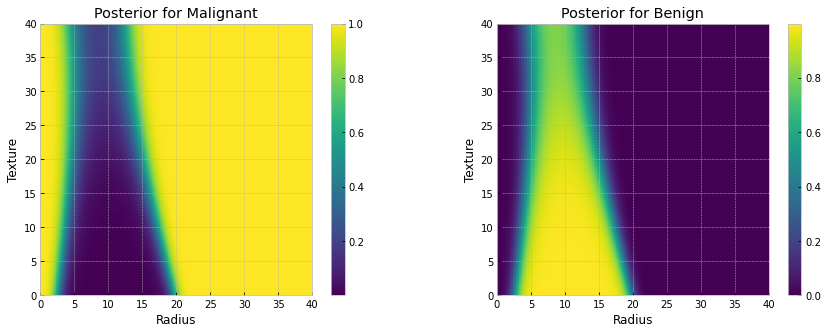

In [18]:
#CALCULATING POSTERIOR
POSmal = Gmal*pMal / (Gmal*pMal + Gben*pBen)
POSben = Gben*pBen / (Gmal*pMal + Gben*pBen)

fig =plt.figure(figsize=(15,5))
fig.add_subplot(1,2,1)
plt.imshow(POSmal, extent=[0,grid,0,grid])
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.title('Posterior for Malignant')

fig.add_subplot(1,2,2)
plt.imshow(POSben, extent=[0,grid,0,grid])
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.title('Posterior for Benign');

Text(0.5, 1.0, 'Region to Decide Malignant')

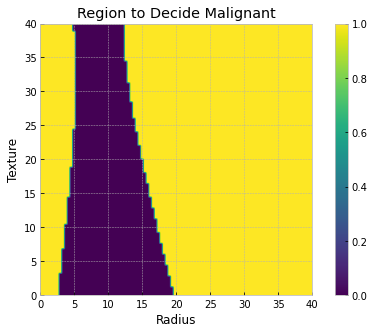

In [19]:
#PLOTTING THE MORE CRISP DECISION BOUNDARY
plt.figure(figsize=(8,5))
plt.imshow(POSmal > POSben, extent=[0,grid,0,grid])
plt.colorbar()
plt.xlabel('Radius')
plt.ylabel('Texture')
plt.title('Region to Decide Malignant')

In [23]:
newPoint = np.array([18,22])

mal_y = stats.multivariate_normal.pdf(newPoint, mean=MLEmal, cov=COVmal)
ben_y = stats.multivariate_normal.pdf(newPoint, mean=MLEben, cov=COVben)

mal_pos = mal_y*pMal / (mal_y*pMal + ben_y*pBen)
ben_pos = ben_y*pBen / (mal_y*pMal + ben_y*pBen)

print(mal_pos)
print(ben_pos)

if mal_pos > ben_pos:
    print(f'New point = {newPoint} is Malignant')
else:
    print(f'New point = {newPoint} is Benign')

0.9932670147244329
0.006732985275567139
New point = [18 22] is Malignant


I am very confident that the data point above is malignant. When looking at the Gaussian for malignant cells, it falls near the center. The posterior for this data point puts the likely hood of malignant at virtually 100%.

In [25]:
newPoint = np.array([30,30])

mal_y = stats.multivariate_normal.pdf(newPoint, mean=MLEmal, cov=COVmal)
ben_y = stats.multivariate_normal.pdf(newPoint, mean=MLEben, cov=COVben)

mal_pos = mal_y*pMal / (mal_y*pMal + ben_y*pBen)
ben_pos = ben_y*pBen / (mal_y*pMal + ben_y*pBen)

print(mal_pos)
print(ben_pos)

if mal_pos > ben_pos:
    print(f'New point = {newPoint} is Malignant')
else:
    print(f'New point = {newPoint} is Benign')

1.0
1.4203002223082662e-20
New point = [30 30] is Malignant


This data point lies far away from both Gaussians and lies deep within the classification zone for malignant. Although this doesn't necessarily mean that since the point doesn't lie inside the benign zone that it is automatically malignant. The posterior puts the probability of this data point being malignant at 100%. I would be skeptical since it lies so far from the malignant Gaussian but, with just the data I have in front of me, I would say that the classifier is correct in its output with moderate certainty.

# Submit Your Solution

Confirm that you've successfully completed the assignment.

Along with the Notebook, include a PDF of the notebook with your solutions.

```add``` and ```commit``` the final version of your work, and ```push``` your code to your GitHub repository.

Submit the URL of your GitHub Repository as your assignment submission on Canvas.